In [32]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
import random
from matplotlib import pyplot as plt
from pair_trading_foundations.data_generation import ExecutePairTrading, generate_training_data
random.seed(23)
import cProfile
import pstats
import pickle
import plotly.express as px
from time import time
import warnings
warnings.filterwarnings('ignore')

def chunker(seq, size):
    # split a list into chunks
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [33]:
# data = pd.read_csv('Data/sp500_full_20181231_to_20231229.csv')
data = pd.read_csv('Data/sp500_full_19991201_to_20231231.csv')
value_count_tb = data[['Ticker']].groupby('Ticker').size().reset_index()
value_count_tb.columns = ['Ticker', 'Count']
stock_to_keep = value_count_tb['Ticker'][value_count_tb.Count==value_count_tb.Count.max()]
data = data[data.Ticker.isin(stock_to_keep)]

# Generate for all pairs

In [35]:
tickers = list(set(data.Ticker.values))
combinations = list(itertools.combinations(tickers, 2))
len(combinations)
batches = list(chunker(combinations, 1000))

In [36]:
len(data)

2169122

In [50]:
from importlib import reload
import pair_trading_foundations.data_generation
reload(pair_trading_foundations.data_generation)
from pair_trading_foundations.data_generation import ExecutePairTrading, generate_training_data

i = 0
for batch in batches:
    start_ts=time()
    print(f'Getting {i+1}th out of {len(batches)} batches')
    max_pairs = 1
    features_tb, labels_tb = generate_training_data(
        data=data,
        moving_average=20,
        training_len=300,
        test_len=20,
        entry_signal=2,
        exit_signal=0.2,
        calculate_label=True,
        verbose=False,
        max_combinations=max_pairs,
        combinations=batch
    )
    combined = pd.merge(features_tb, labels_tb, how='left', on=['Date', 'Ticker_P1','Ticker_P2']).reset_index(drop=True)
    combined = combined[combined.pnls.notnull()].reset_index(drop=True)
    combined.to_csv(f'Data/Training/pair_features_{i+1}_pairs{max_pairs}_300_120.csv', index=False)
    end_ts = time()
    print(f"Took {end_ts - start_ts} seconds")
    i+=1
    break
    
len(combined)
combined

Getting 1th out of 64 batches
1000 stock pairs detected
Took 0.4926445484161377 to initilize. Entering ticker pair loop
Max combination = 1
Took 10.819144010543823 to finish
Took 10.917511940002441 seconds


,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,Close_P2,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,pnls,actual_abs_spread_std
0,LHX,2001-02-08 00:00:00,13.614568,13.335852,589966.0,8.946339,HST,12.697014,12.530592,289289.0,6.479646,2.466692,4.442458,1.363024,2.231293,0.319689,0.000000,0.441095
1,LHX,2001-02-09 00:00:00,13.652360,12.991000,774767.0,8.626379,HST,12.716593,12.491434,368046.0,6.429377,2.197002,4.440955,1.365257,2.213434,0.310549,0.000000,0.437215
2,LHX,2001-02-12 00:00:00,13.321680,12.877624,939881.0,8.642060,HST,12.736172,12.471855,436589.0,6.504780,2.137280,4.438774,1.368419,2.197679,0.305744,0.000000,0.438563
3,LHX,2001-02-13 00:00:00,13.699600,13.179960,930356.0,8.946339,HST,12.814488,12.638277,435057.0,6.524886,2.421453,4.437382,1.370263,2.218503,0.306111,0.000000,0.408544
4,LHX,2001-02-14 00:00:00,13.784632,13.293336,881456.0,8.952612,HST,12.716593,12.628488,560293.0,6.529912,2.422700,4.436068,1.372011,2.239980,0.304534,0.000000,0.365675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,LHX,2023-11-24 00:00:00,191.009995,188.050003,482300.0,191.009995,HST,17.469999,17.250000,1743300.0,17.031353,173.978642,179.347756,17.309478,166.340385,4.529981,0.023326,6.668684
5735,LHX,2023-11-27 00:00:00,190.860001,187.369995,676200.0,187.919998,HST,17.490000,17.219999,4290800.0,17.041130,170.878868,179.227780,17.242673,167.125519,3.794203,0.029638,6.319925
5736,LHX,2023-11-28 00:00:00,189.740005,187.679993,726600.0,189.100006,HST,17.650000,17.320000,4449600.0,17.197561,171.902445,179.111175,17.173164,167.807507,3.312582,0.030869,5.912143
5737,LHX,2023-11-29 00:00:00,189.779999,188.059998,661800.0,188.660004,HST,17.780001,17.410000,4099200.0,17.050907,171.609097,178.998401,17.110651,168.228751,3.228321,0.026872,5.338684


count    5739.000000
mean        0.000573
std         0.023840
min        -0.185542
25%         0.000000
50%         0.000000
75%         0.003239
max         0.156700
Name: pnls, dtype: float64

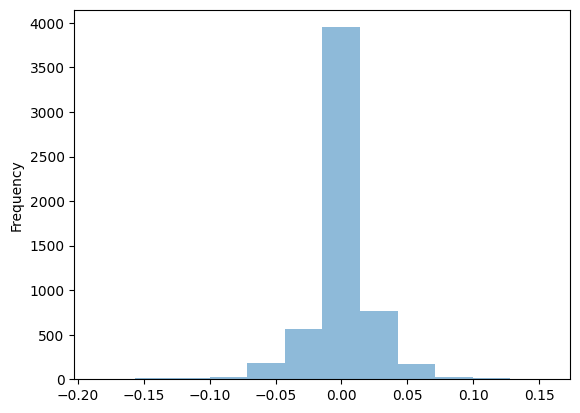

In [51]:
labels_tb
labels_tb = labels_tb.dropna()
labels_tb.pnls.plot.hist(bins=12, alpha=0.5)
labels_tb.pnls.describe()